# From Notebook to ModelOp Center:

## Training, Evaluating, and Conforming a Model for Deployment
In this notebook, we demonstrate the process of
1. simple cleaning, feature engineering, and feature selection of a dataset,
2. training a model,
3. evaluating model performance,
4. saving (pickling) the model (and other assets) for later use,
5. and conforming the code into MOC standard

More specifically, we will train a linear regression predictor on the Ames Housing Data dataset.

Let's load in the necessary libraries. We will be using `sklearn` to train the model.

In [1]:
import pickle
import pandas
import numpy
import copy
import seaborn

from sklearn import set_config
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#set_config(display='diagram')
pandas.options.mode.chained_assignment = None

**I - Data Cleaning, Feature Engineering, and Feature Selection**

The **Ames Housing Data** dataset can be found [at this link](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). Download the train dataset (we will be using it exclusively as those have all have an actual SalePrice value, our ground truth to use with the monitoring capabilities of ModelOp Center) and load it into a Pandas DataFrame.

In [2]:
df = pandas.read_csv('./house_price_data.csv')

In [3]:
df.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'Pav

Let's look at the top of the data:

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Before proceeding, let's split the original dataset into two sets: a **baseline** set which will be used as a reference set, and a **sample** set which will mimic input data to the model once the model is in use.

We'l also prepare a `_scored` version of the dataframes for later use during our MOC monitoring phase. In that DataFrame, we'll mainly be using the `ground_truth`, which in our case is `SalePrice`, and `predictions` (later to be added) to compare drift, bias, and other metrics that we will want to monitor in the lifecycle of the model.

In [5]:
df_baseline, df_sample = train_test_split(df, train_size=0.8, random_state=777)

df_baseline_scored = df_baseline.copy(deep=True)
df_sample_scored = df_sample.copy(deep=True)

df_baseline.to_json('df_baseline.json', orient='records', lines=True)
df_sample.to_json('df_sample.json', orient='records', lines=True)

Let's **clean up** the data. There are quite a few null values in the dataset and we'll fill them in with appropriate values. Note that these steps will also be necessary once we want to write code that conforms to ModelOp standards.

In [6]:
print('Numerical features that contain 1 or more missing values:')
for col, dtype in df.dtypes.items():
    if dtype != 'object' and df[col].isna().sum() > 0:
        print('- ', col)

Numerical features that contain 1 or more missing values:
-  LotFrontage
-  MasVnrArea
-  GarageYrBlt


In [7]:
# imputing missing GarageYrBlt values with corresponding YrBlt values
df_baseline.loc[:,'GarageYrBlt'] = df_baseline.loc[:, 'GarageYrBlt'].fillna(df_baseline['YearBuilt'])
df_sample.loc[:,'GarageYrBlt'] = df_sample.loc[:, 'GarageYrBlt'].fillna(df_sample['YearBuilt'])

In [8]:
# imputing `MasVnrArea` missing values with 0 and 
df_baseline.loc[:, 'MasVnrArea'] = df_baseline.loc[:, 'MasVnrArea'].fillna(0)
df_sample.loc[:, 'MasVnrArea'] = df_sample.loc[:, 'MasVnrArea'].fillna(0)

In [9]:
# `LotFrontage` missing values with the median value of the neighborhood
df_baseline['LotFrontage'] = df_baseline.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_baseline['LotFrontage'] = df_baseline['LotFrontage'].fillna(0)
df_sample['LotFrontage'] = df_sample.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_sample['LotFrontage'] = df_sample['LotFrontage'].fillna(0)

/Users/smerhi/anaconda3/envs/modelop/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [10]:
# imputing the rest of the missing values in categorical features with 'None'
for col in list(df.columns):
    df_baseline.loc[:, col] = df_baseline.loc[:, col].fillna('None')
    df_sample.loc[:, col] = df_sample.loc[:, col].fillna('None')

Next, let's write up some functions that will convert some categorical features into numerical features, then apply those functions to our data.

In [11]:
# Many columns use this generic scale
generic = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "None": 0}
fireplace_quality = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0}
garage_finish = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
fin_type = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
functional = {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'None': 0}

In [12]:
# Generic conversions
generic_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond', 'PoolQC']
for col in generic_columns:
    df_baseline.loc[:, col] = df_baseline[col].map(generic)
    df_sample.loc[:, col] = df_sample[col].map(generic)

In [13]:
# FireplaceQu convervsions
df_baseline.loc[:, 'FireplaceQu'] = df_baseline['FireplaceQu'].map(fireplace_quality)
df_sample.loc[:, 'FireplaceQu'] = df_sample['FireplaceQu'].map(fireplace_quality)

In [14]:
# FinType conversions
fintype_columns = ['BsmtFinType1', 'BsmtFinType2']
for col in fintype_columns:
    df_baseline.loc[:, col] = df_baseline[col].map(fin_type)
    df_sample.loc[:, col] = df_sample[col].map(fin_type)

In [15]:
# Functional conversion
df_baseline.loc[:, 'Functional'] = df_baseline['Functional'].map(functional)
df_sample.loc[:, 'Functional'] = df_sample['Functional'].map(functional)

In [16]:
# GarageFinish conversion
df_baseline.loc[:, 'GarageFinish'] = df_baseline['GarageFinish'].map(garage_finish)
df_sample.loc[:, 'GarageFinish'] = df_sample['GarageFinish'].map(garage_finish)

We also have the `MSSubClass` numerical column which should be treated as a categorical column. We will convert this into an onject column to later be one-hot encoded.

In [17]:
df_baseline['MSSubClass'] = df_baseline['MSSubClass'].astype(str)
df_sample['MSSubClass'] = df_sample['MSSubClass'].astype(str)

Our data still contains non-predictive features, such as `Id` and `SalePrice`. We will set these aside and remove them the final list of predictive features.

In [18]:
df_baseline_ids = df_baseline['Id']
df_sample_ids = df_sample['Id']

predictive_features = [
    f for f in list(df.columns.values)
    if f not in ['Id', 'SalePrice']
]

Everything looks good; we'll proceed with model training. We need to specify **predictive** and **responsive** variables for each of the training and test sets. We'll set those by filtering the baseline and sample sets.

In [19]:
X_train = df_baseline[predictive_features]
X_test = df_sample[predictive_features]

y_train = df_baseline['SalePrice']
y_test = df_sample['SalePrice']

Let's take a look at which columns contain muerical data and which contain categorical data. Some categorical features can easily be converted to numerical, as they might hold some order of value. Other categorical features will have to be one-hot encoded.

In [20]:
numerical_features = []
categorical_features = []
for i,j in zip(X_train.dtypes.index, X_train.dtypes.values):
    if j=='object':
        categorical_features.append(i)
    else:
        numerical_features.append(i)

**Categorical Features**

In [21]:
print(categorical_features)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


**Numerical Features**

In [22]:
print(numerical_features)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold']


In [23]:
# One hot encoding with pandas.get_dummies()
X_train = pandas.get_dummies(X_train, columns=categorical_features)
X_test = pandas.get_dummies(X_test, columns=categorical_features)

Let's do some **feature engineering**. While this portion of a data science project can be lengthy, we'll be doing some basic feature engineering in this example. A few ones that might be helpful are boolean features like `HasGarage` or `HasBsmt` and additive features like `TotalSF` or `TotalBathrooms`. We'll be adding `e` as a prefix to these columns to show that they have been engineered.

In [24]:
for data in [X_train, X_test]:
    #  computing total square footage as a new feature
    data['eTotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

    #  Computing total 'porch' square-footage as a new feature
    data['eTotalPorchSF'] = (data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])
    
    #  Computing total bathrooms as a new feature
    data['eTotalBathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))

In [25]:
# Engineering some features into Booleans
f = lambda x: bool(1) if x > 0 else bool(0)

for data in [X_train, X_test]:
    data['eHasPool'] = data['PoolArea'].apply(f)
    data['eHasGarage'] = data['GarageArea'].apply(f)
    data['eHasBsmt'] = data['TotalBsmtSF'].apply(f)
    data['eHasFireplace'] = data['Fireplaces'].apply(f)
    # feature to determine if a house had a remodeling
    data['eHasRemodeling'] = data['YearRemodAdd'] - data['YearBuilt'] > 0

Let's engineer one more feature, `OverallQual_TotalSF`. This feature will be the multiplication of the `OverallQual` and `TotalSF` features. This specific combination of features, in fact, has the highest correlation to `SalePrice`.

In [26]:
for data in [X_train, X_test]:
    data['eOverallQual_TotalSF'] = data['OverallQual'] * data['eTotalSF']

Let's move on to **feature selection**. We want our final model to only have a limited number of features, as too many features will cause the model to overfit, though too little will not allow our model to perform well. We'll take a look at the correlation of `SalePrice` to all other columns to determine which ones have the most predictive power, and choose 10 features to predict with.

In [27]:
X_train['SalePrice'] = df['SalePrice']

In [28]:
strong_cols = [(col, round(corr, 2)) for col, corr in X_train.corr()['SalePrice'].items() if abs(corr) > 0.4]
strong_cols.sort(key=lambda x:x[1])
strong_cols

[('Neighborhood_NridgHt', 0.4),
 ('BsmtFinSF1', 0.41),
 ('HeatingQC', 0.43),
 ('Fireplaces', 0.46),
 ('eHasFireplace', 0.47),
 ('MasVnrArea', 0.48),
 ('Foundation_PConc', 0.5),
 ('FireplaceQu', 0.51),
 ('YearRemodAdd', 0.52),
 ('TotRmsAbvGrd', 0.52),
 ('GarageYrBlt', 0.52),
 ('YearBuilt', 0.53),
 ('FullBath', 0.55),
 ('GarageFinish', 0.55),
 ('1stFlrSF', 0.6),
 ('TotalBsmtSF', 0.61),
 ('GarageArea', 0.62),
 ('BsmtQual', 0.63),
 ('eTotalBathrooms', 0.63),
 ('GarageCars', 0.64),
 ('KitchenQual', 0.66),
 ('ExterQual', 0.69),
 ('GrLivArea', 0.7),
 ('eTotalSF', 0.77),
 ('OverallQual', 0.78),
 ('eOverallQual_TotalSF', 0.84),
 ('SalePrice', 1.0)]

In [29]:
# the final list of encoded columns
train_encoded_columns = ['eOverallQual_TotalSF', 'OverallQual', 'eTotalSF', 'GrLivArea',
                         'ExterQual', 'KitchenQual', 'GarageCars', 'eTotalBathrooms', 'BsmtQual', 
                         'GarageArea', 'TotalBsmtSF', 'GarageFinish', 'YearBuilt', 'eHasGarage', 'TotRmsAbvGrd', 
                         'eHasRemodeling', 'FireplaceQu', 'MasVnrArea', 'eHasFireplace', 'eHasBsmt']

**II - Training the model**

Let's move on to training the model. Let's first restrict our feature space to only be that of the final list of columns. We'll be saving this list, as we'll need it when we deploy the model.

In [30]:
# restricting X_train and X_test columns to only be final list of columns
X_train = X_train[train_encoded_columns]
X_test = X_test[train_encoded_columns]

# Saving the final list of encoded columns
pickle.dump(train_encoded_columns, open('train_encoded_columns.pickle', 'wb'))

Another thing we can do to make our model a bit more performant, as well as explainable, is to standardize the features. This will allow us to interpret the weights on each feature directly against each other.

In [31]:
X_test.dtypes

eOverallQual_TotalSF      int64
OverallQual               int64
eTotalSF                  int64
GrLivArea                 int64
ExterQual                 int64
KitchenQual               int64
GarageCars                int64
eTotalBathrooms         float64
BsmtQual                  int64
GarageArea                int64
TotalBsmtSF               int64
GarageFinish              int64
YearBuilt                 int64
eHasGarage                 bool
TotRmsAbvGrd              int64
eHasRemodeling             bool
FireplaceQu               int64
MasVnrArea              float64
eHasFireplace              bool
eHasBsmt                   bool
dtype: object

In [32]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(numpy.array(X_train))
X_test_ss = ss.transform(numpy.array(X_test))
pickle.dump(ss, open('standard_scaler.pickle', 'wb'))

One last thing we can do is to apply a logarithm to `SalePrice`. If we look at the distribution of values for `SalePrice`, we can notice that there is a right skew, with values at the top of the distribution quite distant from the average value of the distribution.

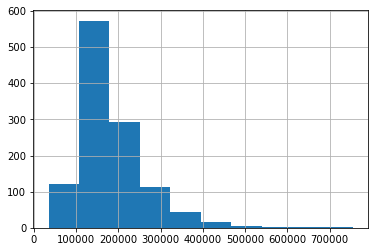

In [33]:
y_train.hist();

Applying a logarithm will allow the distribution to be centralized, allowing our model that will be trained to be more performant. We'll specifically use the `numpy.log1p()` function in case that there are values are 0. 

In [34]:
y_train_log = numpy.log1p(y_train)
y_test_log = numpy.log1p(y_test)

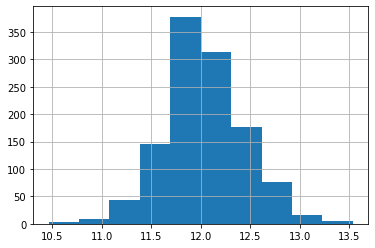

In [35]:
y_train_log.hist();

The distribution is now roughly normalized, and the model should be able to predict better. One thing we need to keep in mind, however, is that if we want predictions, we will have to inverse the logarithm on the outputs of the model.

We will train a **Lasso** linear regression model. Let's fit the model to the training data.

In [36]:
# finding the cross-validation score with 5 (default) folds, showing how the model should generally perform, irrespective to how the data was split
cross_val_score(LassoCV(max_iter=5000), X_train_ss, y_train_log).mean()

0.8167504671863934

In [37]:
lasso = LassoCV(max_iter=5000)
lasso.fit(X_train_ss, y_train_log)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=5000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [38]:
lasso.score(X_train_ss, y_train_log)

0.8430704847122994

In [39]:
lasso.score(X_test_ss, y_test_log)

0.8580636796558804

**III - Model Evaluation**

Before saving our trained model for further use, let's take a look at some performance metrics. We will evaluate the model on both the training and test sets; we want to see a stable performance between the two.  

For repeatability, let's define a function which computes multiple metrics at once.

In [40]:
def compute_metrics(y, y_preds):
    """
    A function to evaluate a regression model.
    
    param: y: true (ground truth) values
    param: y_preds: predicted values (as predicted by model)
    
    return: multiple regression performance metrics
    """
    
    return {
        'Mean Absolute Error' : round(mean_absolute_error(y, y_preds), 2),
        'Root Mean Squared Error' : round(mean_squared_error(y, y_preds) ** 0.5, 2),
        'R2 Score' : round(r2_score(y, y_preds), 3)
    }

Let's compute predictions on both training and test sets. Remember, we need to apply an inverse log to convert the outputs into the same units as our inputs.

In [41]:
y_train_preds = numpy.round(numpy.expm1(lasso.predict(X_train_ss)), 2)
y_test_preds = numpy.round(numpy.expm1(lasso.predict(X_test_ss)), 2)

In [42]:
performance_df = pandas.DataFrame(
    data=[{}],
    columns=['Mean Absolute Error', 'Root Mean Squared Error', 'R2 Score'],
    index=['Training Set', 'Test Set']
)
performance_df.loc['Training Set', :] = compute_metrics(y_train, y_train_preds)
performance_df.loc['Test Set', :] = compute_metrics(y_test, y_test_preds)

Let's look at how our model performed:

In [43]:
performance_df

,Mean Absolute Error,Root Mean Squared Error,R2 Score
Training Set,20914.02,36422.12,0.801
Test Set,16715.31,23450.18,0.885


There is a slight difference in performance between the training set and the test set on some of the metrics. This could have come from the way that the data was split, or other issues. Further model improvements are needed to achieve more accurate inferences. For now, we will contend with this model and use it to produce new predictions.

**IV - Saving and Loading the Trained Model**

Now that the model is **trained** and **evaluated**, we save it in a binary format. It will later be loaded and used to make new predictions.

In [44]:
pickle.dump(lasso, open('lasso.pickle', 'wb'))

The model is reloaded on-demands as follows:

In [45]:
lasso_loaded = pickle.load(open('lasso.pickle', 'rb'))

Predictions can be produced on-demand by calling the `predict()` function:

In [46]:
new_preds = lasso_loaded.predict(X_test)

Before heading into the next section, let's append our predictions to our `_scored` DataFrames and save them. Once again, these data sets will be used mainly for monitoring purposes. Note that the features on these datasets will be the final list of features used that the model expects during prediction.

In [47]:
all_cols = train_encoded_columns.copy()

all_cols.append('SalePrice')

cols_reordered = ['Id', 'prediction', 'SalePrice']
cols_reordered.extend(train_encoded_columns)

X_train['SalePrice'] = y_train
X_test['SalePrice'] = y_test

df_baseline_scored = X_train[all_cols]
df_baseline_scored['prediction'] = y_train_preds
df_baseline_scored['Id'] = df_baseline_ids
df_baseline_scored = df_baseline_scored[cols_reordered]

df_sample_scored = X_test[all_cols]
df_sample_scored['prediction'] = y_test_preds
df_sample_scored['Id'] = df_sample_ids
df_sample_scored = df_sample_scored[cols_reordered]

df_baseline_scored.to_json('df_baseline_scored.json', orient='records', lines=True)
df_sample_scored.to_json('df_sample_scored.json', orient='records', lines=True)

**V - Conforming Model Code to MOC Requirements**

Conformance is best demonstrated through example. Let's look at the code below:

In [48]:
import pandas
import pickle
import numpy
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# modelop.init
def begin():
    global lasso_model
    global standard_scaler
    global train_encoded_columns

    # load pickled Lasso linear regression model
    lasso_model = pickle.load(open("lasso.pickle", "rb"))
    # load pickled standard scaler
    standard_scaler = pickle.load(open("standard_scaler.pickle", "rb"))
    # load train_encoded_columns
    train_encoded_columns = pickle.load(open("train_encoded_columns.pickle", "rb"))


# modelop.score
def action(data):
    # turning data into a dataframe
    df = pandas.DataFrame([data])

    # set aside ground truth to later re-append to dataframe
    ground_truth = df["SalePrice"]
    
    # dictionaries to convert values in certain columns
    generic = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "None": 0}
    fireplace_quality = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0}
    garage_finish = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
    
    # imputations
    df.loc[:,'GarageYrBlt'] = df.loc[:, 'GarageYrBlt'].fillna(df['YearBuilt'])
    for col in ['GarageFinish', 'BsmtQual', 'FireplaceQu']:
        df.loc[:, col] = df.loc[:, col].fillna('None')
    # the rest of NaNs will be filled with 0s - end model only uses numerical features
    for col in df.columns:
        df[col] = df[col].fillna(0)
    
    # converting categorical values from certain features into numerical
    for col in ["BsmtQual", "KitchenQual", "ExterQual"]:
        df.loc[:, col] = df[col].map(generic)
    df.loc[:, 'GarageFinish'] = df['GarageFinish'].map(garage_finish)
    df.loc[:, 'FireplaceQu'] = df['FireplaceQu'].map(fireplace_quality)

    # feature engineering
    f = lambda x: bool(1) if x > 0 else bool(0)
    df['eHasPool'] = df['PoolArea'].apply(f)
    df['eHasGarage'] = df['GarageArea'].apply(f)
    df['eHasBsmt'] = df['TotalBsmtSF'].apply(f)
    df['eHasFireplace'] = df['Fireplaces'].apply(f)
    df['eHasRemodeling'] = df['YearRemodAdd'] - df['YearBuilt'] > 0
    df['eTotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['eTotalBathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df['eOverallQual_TotalSF'] = df['OverallQual'] * df['eTotalSF']
    
    # limiting features to just the ones the model needs
    df = df[train_encoded_columns]

    # scale inputs
    df_ss = standard_scaler.transform(df)

    # generate predictions and rename columns
    df.loc[:, "prediction"] = numpy.round(numpy.expm1(lasso_model.predict(df_ss)), 2)
    df.loc[:, "SalePrice"] = ground_truth

    # MOC expects the action function to be a "yield" function
    # for local testing, we use "return" to visualize the output
    # yield df.to_dict(orient='records')
    return df.to_dict(orient="records")


# modelop.metrics
def metrics(data):
    # converting data into dataframe
    df = pandas.DataFrame(data)

    y = df["SalePrice"]
    y_preds = df["prediction"]
   
    output_metrics = {
        "MAE": mean_absolute_error(y, y_preds),
        "RMSE": mean_squared_error(y, y_preds) ** 0.5,
        "R2": r2_score(y, y_preds),
    }
    
    # MOC expects the metrics function to be a "yield" function
    # yield output_metrics
    return output_metrics

There are four main sections that are standard to almost any model in MOC:
1. Library imports
2. `init` function
3. `score` function
4. `metrics` function

**Library** imports are always at the top. We don't need to include all libraries that we used for training and model evaluation. We just need the libraries for processing and scoring.

The **`init`** function runs once per deployment, and is used to load and persist into memory any variable that needs to be accessed at scoring time. For example, the init function is where we load the saved model binary. We make the variable global so it can be accessed from the scoring function. In our example, we also included the `train_encoded_columns` as this information will not change per prediction and only needs to be instantiated once.

The **`score`** function is the function that runs anytime we make a scoring (prediction) request. This is where we put our prediction code. We have to remember to include any steps that were not captured by the pipeline, such as feature engineering or re-encoding.

The **`metrics`** functions is where model evaluation is carried out. In our example, this is the place where we replicate the calculations of Group and/or Bias metrics.

Let us test our source code to see if we missed anything. We will load input data and scored input data to test both the scoring and metrics functions:

In [49]:
# this is for the action function (scoring)
test_sample = pandas.read_json('df_baseline.json', orient='records', lines=True)

# these are for the metrics function
metrics_baseline_input = pandas.read_json('df_baseline_scored.json', orient='records', lines=True)
metrics_sample_input = pandas.read_json('df_sample_scored.json', orient='records', lines=True)

Let's check that the **`init`** function can load the trained model binary:

In [50]:
begin()

No errors from the **`init`** function. Let's make a call to the **`score`** function on input data:

In [51]:
scores = pandas.DataFrame(action(test_sample.iloc[0]))

In [52]:
scores

,eOverallQual_TotalSF,OverallQual,eTotalSF,GrLivArea,ExterQual,KitchenQual,GarageCars,eTotalBathrooms,BsmtQual,GarageArea,...,YearBuilt,eHasGarage,TotRmsAbvGrd,eHasRemodeling,FireplaceQu,MasVnrArea,eHasFireplace,eHasBsmt,prediction,SalePrice
0,18192,6,3032,1516,2,2,2,1.5,2,472,...,1964,True,6,False,0,180.0,False,True,156491.21,167000


We scores! Finally, let's call the **`metrics`** function on scored data:

In [53]:
metrics_compare = pandas.DataFrame([metrics(metrics_baseline_input), 
                                    metrics(metrics_sample_input)],
                                   index=['baseline', 'sample'])

In [54]:
metrics_compare

,MAE,RMSE,R2
baseline,20914.018767,36422.119215,0.801362
sample,16715.310240,23450.183792,0.885231
